# Inception network

![](../img/inception_1.png)

Bức ảnh trên mô tả về cấu trúc của inception layer. Trong đó từ (28, 28, 192) input ta sẽ thực hiện đưa lần lượt input qua các conv và pool layer gồm:

- 1x1 conv same => output (28, 28, 64)
- 3x3 conv same => output (28, 28, 128)
- 5x5 conv same => ouput (28, 28, 32)
- max-pool (same) => output (28, 28 , 32)

Stack các kết quả lại với nhau được 1 outout có số chiều là (28, 28, 256)

## I. Vấn đề về computation cost

Xét việc áp 5x5 same conv lên input ta có:

![](../img/inception_2.png)

Ta cần sử dụng 32 bộ filter (5x5x192) để thực hiện convolution cho input (28x28x32)

=> cost = 28x28x32 * 5x5x192 = 120M phép nhân

Đây là 1 con số rất lớn.

Tuy nhiên ta có thể giảm thiếu cost trên bằng cách sử dụng thêm 1x1 same conv như sau:

![](../img/inception_3.png)

Bằng cách sử dụng 1x1 same conv (gọi là bottleneck layer) ta thấy rắng computation cost giảm xuống còn 12.4M

## II. Inception module

Giải quyết vấn đề về computation cost như trên cho nên ta sẽ không sử dụng convolution trực tiếp mà sẽ cho đi qua 1x1 same conv layer như sau:

![](../img/inception_4.png)

## III. GoogleNet

![](../img/inception_5.png)

Đây là cấu trúc của mạng GoogLeNet, ta thấy rằng mạng đang sử dụng nhiều Inception layer.
Bên cạnh đó ở một số hidden Inception layer còn có Fully connected layer và softmax => Để dựng đoán labels hay ta có thể nói răng việc sử dụng mạng này cho phép ta dự đoán labels ở bất kì layer nào. Việc sử dụng như vậy giúp ngăn việc overfitting






# Sử dụng Inception NN để thực hiện bài toán detect brain tumor

In [101]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


## Setup device

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Setup folder data to load

In [103]:
listFolder = ["TRAIN/YES", "TRAIN/NO", "TEST/YES", "TEST/NO", "VAL/YES", "VAL/NO"]
for folder in listFolder:
    DIR = f"./data/brain_tumor_dataset/{folder}"
    if not os.path.exists(DIR):
        os.mkdir(DIR)
        
# clean old data
for folder in listFolder:
    DIR = f"./data/brain_tumor_dataset/{folder}"
    for file in os.listdir(DIR):
        os.remove(f"{DIR}/{file}")

print("NEW files created!")


# Preparing folder data and train, test, val set
IMG_PATH = 'data/brain_tumor_dataset/'

for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith(".") and CLASS !='TEST' and CLASS !='TRAIN' and CLASS !='VAL':
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            # split data 30 % for test
            if n< 0.3*IMG_NUM:
                shutil.copy(img, IMG_PATH +"TEST/" + CLASS.upper() + '/' + FILE_NAME)
            # split data 60% for training
            elif n< IMG_NUM*0.9:
                shutil.copy(img, IMG_PATH +"TRAIN/"+ CLASS.upper() + '/' + FILE_NAME)
            # the rest is for validation
            else:
                shutil.copy(img, IMG_PATH +"VAL/" + CLASS.upper() + '/' + FILE_NAME)

print("Successfully migrated data")

NEW files created!
Successfully migrated data


## Hyper parameters

In [104]:
num_epochs = 10
batch_size = 4
learning_rate = 0.0001

## Load data

In [105]:
TRAIN_DIR = './data/brain_tumor_dataset/TRAIN'
TEST_DIR = './data/brain_tumor_dataset/TEST'
VAL_DIR = './data/brain_tumor_dataset/VAL'
IMG_SIZE = (224, 224)

# Take Mean and std
samples_set = datasets.ImageFolder(TRAIN_DIR, transform=transforms.Resize((224, 224)))

def readToNumpy(imagesSet):
    listImgs = []
    for img_path in imagesSet:
        img = cv2.imread(img_path[0])
        listImgs.append(cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA))
    return np.array(listImgs)

listImgs = readToNumpy(samples_set.imgs)

MEAN = (listImgs/255.0).mean((0,1,2))
STD = (listImgs /255.0).std((0,1,2))

MEAN, STD


(array([0.22848128, 0.22868439, 0.22845893]),
 array([0.2244089 , 0.22435379, 0.22396011]))

In [106]:
# This line of code is to auto completion of code using key "Tab". Just make coding faster ^^! 
# I read from this post "https://www.kaggle.com/getting-started/51622"
%config Completer.use_jedi = False

## Preprocessing data

In [107]:
class ImageEnhanced:
    """_summary_
    transform to enhanced image quality for prediction 
    """
    def __init__(self):
        pass
    def __call__(self):
        pass
    
# Data trasform
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop((224,224),scale=(0.8,1.0),ratio=(0.9,1.1))
])

# load data
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)
val_dataset = datasets.ImageFolder(VAL_DIR, test_transform)

# data loader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, drop_last=False)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size, drop_last=False)


## Image visualization

tensor([1, 0, 1, 1])


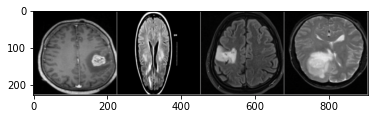

Yes          No           Yes          Yes         


In [108]:
classes = ('No', 'Yes')
NUM_IMGS = batch_size

show_samples = iter(train_loader)
images, labels = show_samples.next()
print(labels)

imgs = torchvision.utils.make_grid(images, normalize=True, pad_value=0.5)

# Convert images to a readable numpy for plt
imgs = imgs.numpy()

# Transform imgs to an array of images
imgs = imgs.transpose((1,2,0))

# Show images
plt.imshow(imgs)
plt.show()

print(' '.join(f'{classes[labels[j]]:12s}' for j in range(NUM_IMGS)))

## Setup Model

### Inception block

In [109]:
class InceptionBlock(nn.Module):
    def __init__(self, c_in, c_red:dict, c_out:dict):
        """_summary_

        Args:
            c_in (_type_): number of channel from previous layer
            c_red (dict): number of 1x1 conv layer whichs is passed to 3x3 and 5x5 conv layer afterwards
            c_out (dict): number of channel of 4 branches
        """
        super().__init__()
        # input -> 1x1 conv -> ouput
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out['1x1'], kernel_size=1),
            nn.BatchNorm2d(c_out['1x1']),
            nn.ReLU()
        )
        #input -> 1x1 conv -> 3x3 conv -> output
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red['3x3'], kernel_size=1),
            nn.BatchNorm2d(c_red['3x3']),
            nn.ReLU(),
            nn.Conv2d(c_red['3x3'], c_out['3x3'], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out['3x3']),
            nn.ReLU()
        )
        # input -> 1x1 conv -> 5x5 conv -> output
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red['5x5'], kernel_size=1),
            nn.BatchNorm2d(c_red['5x5']),
            nn.ReLU(),
            nn.Conv2d(c_red['5x5'], c_out['5x5'], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out['5x5']),
            nn.ReLU()
        )
        # input -> maxpool -> 1x1 conv -> output
        self.maxpool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(c_in, c_out['max'], kernel_size=1),
            nn.BatchNorm2d(c_out['max']),
            nn.ReLU()
        )
    
    def forward(self, x):
        output1x1 = self.conv_1x1(x)
        output3x3 = self.conv_3x3(x)
        output5x5 = self.conv_5x5(x)
        outputmpl = self.maxpool(x)
        
        output = torch.cat([output1x1, output3x3, output5x5, outputmpl], dim=1)
        
        return output

### GoogLeNet

In [110]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes = 2):
        super().__init__()
        self.input = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # Stack Inception block
        self.inception = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16})
        )
           
        # Mapping to classification output by a fully connected layer
        self.output = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.input(x)
        x = self.inception(x)
        x = self.output(x)
        return x
    

googleNet = GoogLeNet()

## Training Model

### Define loss and optimizer

In [111]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(googleNet.parameters(),lr=learning_rate, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,1,50], gamma=0.1)

### Training model


In [112]:
googleNet.to(device)

# Training loop
for epoch in range(num_epochs + 1):
    running_loss = 0.0 
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = googleNet(images)
        
        # loss and optimizer
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # Validation step
    googleNet.eval()
    with torch.no_grad():
        for i, (imgs_val, labels_val) in enumerate(val_loader):
            imgs_val = imgs_val.to(device)
            labels_val = labels_val.to(device)
            
            outputs = googleNet(imgs_val)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    # Display statistics
    if epoch % 10 == 9:
        print(f"Epoch: {epoch +1:3d}, loss: {running_loss/len(train_loader)}, val_acc: {100 * correct / total:.2f}%")
    # Reset training loss
    running_loss = 0.0
print("Training completed!")
            

KeyboardInterrupt: 

## Making prediction

In [ ]:
# Test model on test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = googleNet(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the GoogLeNet on the BRAIN TUMOR test images: {100 * correct / total:.2f} %')